In [1]:
import numpy as np
import Antenna as Antenna
from Catalog import Catalog as cat
from flux import get_gleam_flux_ra_dec as ggf
import pandas as pd
from astropy.io import fits
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook as tqd

In [2]:
%matplotlib notebook

# Define a Hex array and antenna objects

In [3]:
def hex_array(hex_num, sep=14.6, split_core=True):
        # Main Hex
        positions = []
        for row in range(
                hex_num - 1, -hex_num + split_core, -1
        ):  # the + split_core deletes a row
            for col in range(0, 2 * hex_num - abs(row) - 1):
                x_pos = sep * ((-(2 * hex_num - abs(row)) + 2) / 2.0 + col)
                y_pos = row * sep * 3 ** 0.5 / 2
                positions.append([x_pos, y_pos, 0])
        # unit vectors
        up_right = sep * np.asarray([0.5, 3 ** 0.5 / 2, 0])
        up_left = sep * np.asarray([-0.5, 3 ** 0.5 / 2, 0])
        # Split the core into 3 pieces
        if split_core:
            new_pos = []
            for i, pos in enumerate(positions):
                theta = np.arctan2(pos[1], pos[0])
                if pos[0] == 0 and pos[1] == 0:
                    new_pos.append(pos)
                elif -np.pi / 3 < theta < np.pi / 3:
                    new_pos.append(np.asarray(pos) + (up_right + up_left) / 3)
                elif np.pi / 3 <= theta < np.pi:
                    new_pos.append(np.asarray(pos) + up_left - (up_right + up_left) / 3)
                else:
                    new_pos.append(pos)
            positions = new_pos
        return {i: pos for i, pos in enumerate(np.array(positions))}

In [4]:
hex_arr = hex_array(2, split_core=False)

ants = {}
for ant_num,pos in hex_arr.items():
    ants[ant_num] = Antenna.Ant(ant_num,pos)
    

<IPython.core.display.Javascript object>


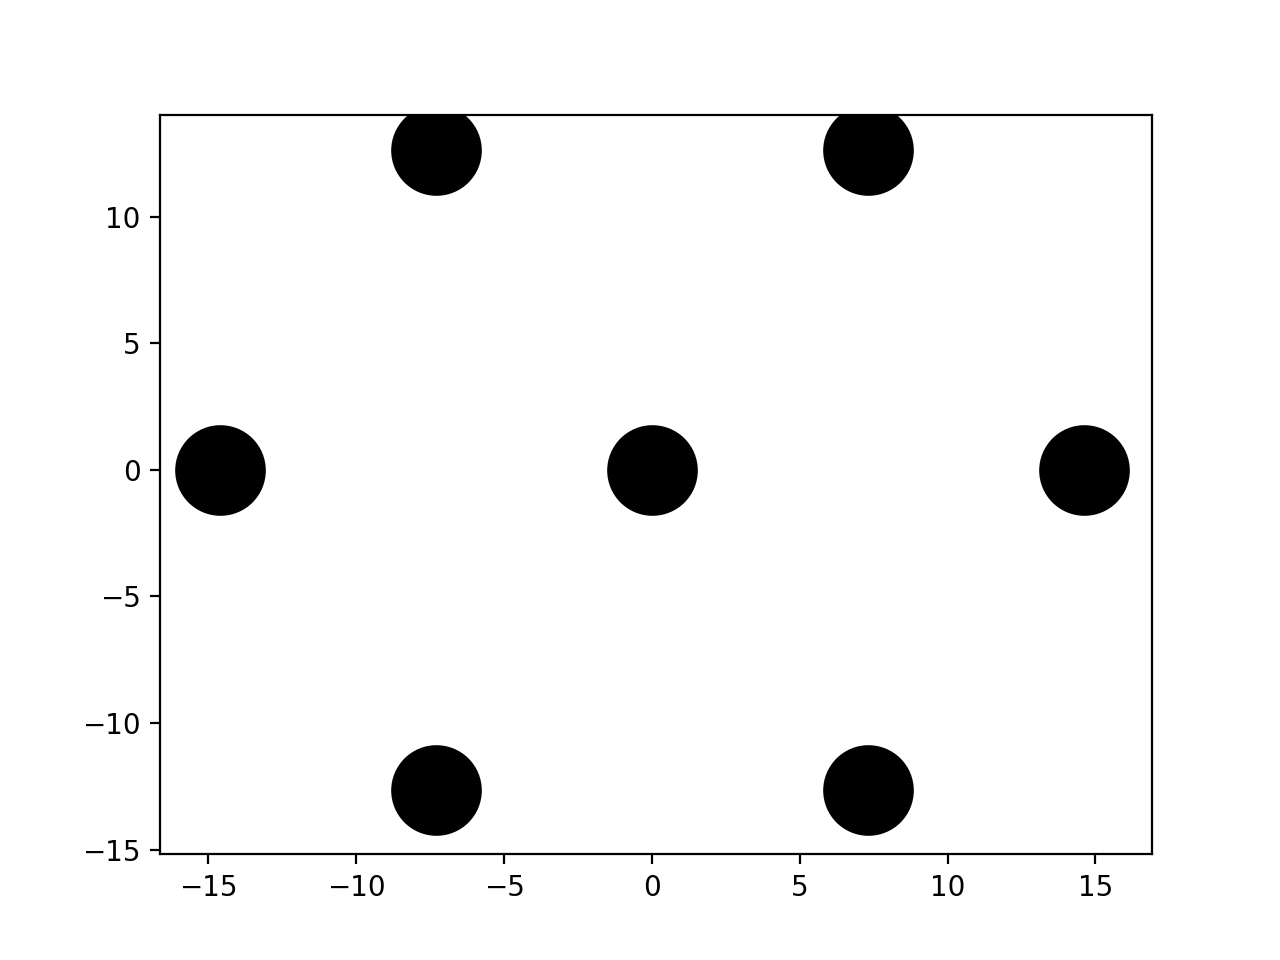

In [5]:
plt.figure()
for ant, pos in hex_arr.items():
    plt.scatter(pos[0], pos[1], color='k', s=1000)

# Bring in GLEAM data

In [6]:
hdul = fits.open("/Users/maxlee/Desktop/Research/ULAB/GLEAM_EGC_v2.fits")
frame = pd.DataFrame(hdul[1].data)

In [13]:
#Set the times and frequencies for the project
time=np.linspace(0,2*np.pi, 50)
freqs=np.linspace(140, 160, 20)

#Find the flux, ra, and dec
c_flux, c_ra, c_dec = ggf(frame, freqs,time, 500)

In [14]:
#Make the catalog object for gleam
c = cat('GLEAM', c_ra, c_dec, c_flux, time, freqs)


# cat_gsm = ('GSM', gsm_ra, gsm_dec, gsm_flux, time, freqs)

# Calculate the visibility

In [15]:
c.freqMHz

array([140.        , 141.05263158, 142.10526316, 143.15789474,
       144.21052632, 145.26315789, 146.31578947, 147.36842105,
       148.42105263, 149.47368421, 150.52631579, 151.57894737,
       152.63157895, 153.68421053, 154.73684211, 155.78947368,
       156.84210526, 157.89473684, 158.94736842, 160.        ])

In [16]:
def visibility(flux,beam,phase):
    return np.einsum('ji,ikj->kj',flux,beam*phase)

def run(ants,catalog):
    bls = {}
    beams = {}
    vis = {}
    flux = catalog.flux
    for i, ant_i in tqd(ants.items(), leave=False, desc='ant_i'):
        for j, ant_j in tqd(ants.items(), leave=False, desc='ant_j'):
            if i <= j:
                #Calculate the baseline vector
                bls[(i,j)]=np.subtract(ant_i.position,ant_j.position) #Baseline works
                
                #Calculate the beam
                beam_i = ant_i.airy_beam(catalog.s_vectors[0], catalog.s_vectors[1], catalog.freqMHz*1e6)
                beam_j = ant_j.airy_beam(catalog.s_vectors[0], catalog.s_vectors[1], catalog.freqMHz*1e6)
                beam = np.sqrt(beam_i*beam_j)
                beams[(i,j)] = beam
                
                #Calculate the phase
                phase = catalog.getPhase(bls[i,j])
                
                #Calculate the visibility
                vis[(i,j)] =visibility(flux,beam,phase)

    return bls, beams, vis

In [17]:
bls, beams, vis = run(ants,c)

/Users/maxlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/Users/maxlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


# Some plots

<IPython.core.display.Javascript object>


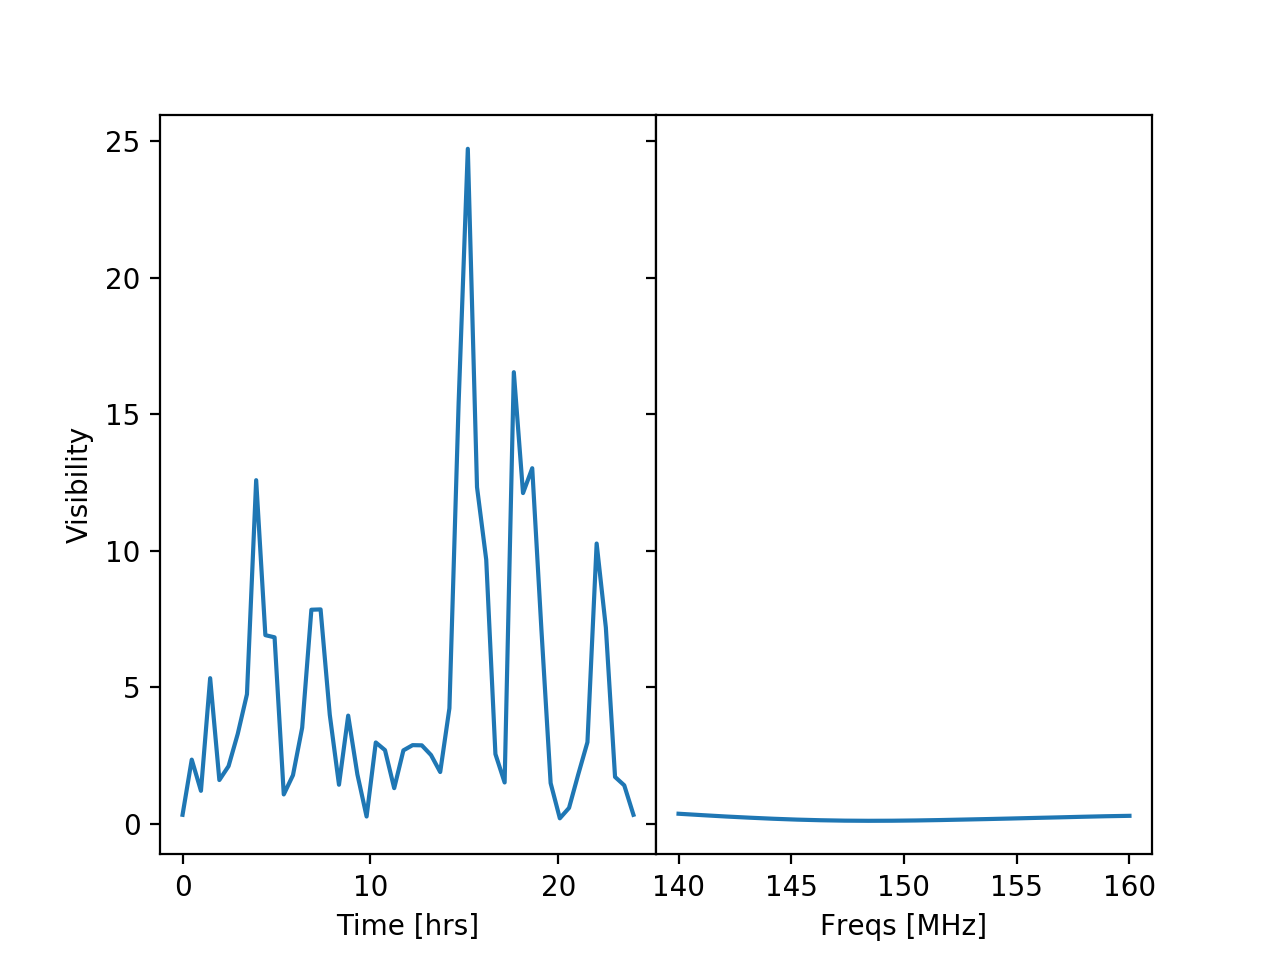

In [18]:
fig, axs = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0})
axs[0].plot(time*12/np.pi, np.abs(vis[(0,1)][:,2]))
axs[0].set_xlabel('Time [hrs]')
axs[0].set_ylabel('Visibility')
axs[1].plot(freqs, np.abs(vis[(0,1)][20,:]))
axs[1].set_xlabel('Freqs [MHz]')

plt.show()

<IPython.core.display.Javascript object>


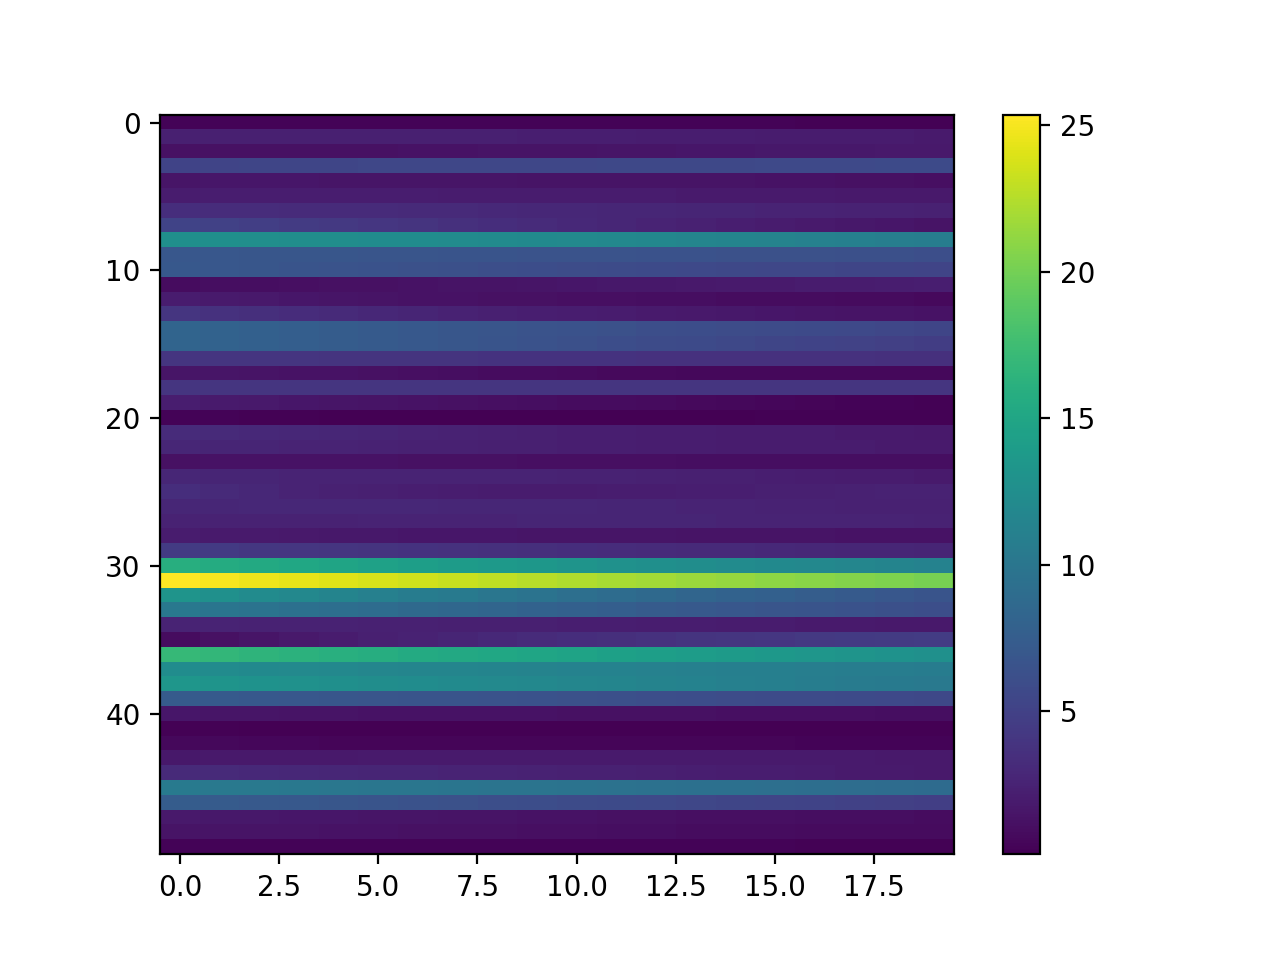

In [19]:
plt.figure()
plt.imshow(np.abs(vis[(0,1)]), aspect = 'auto')
plt.colorbar()

In [20]:
vis_f = {bl: np.fft.fft2(vis[bl]) for bl in vis}
fringe = np.fft.fftshift(np.fft.fftfreq(len(time), np.median(np.diff(time*12/np.pi*3600))))
delay  = np.fft.fftshift(np.fft.fftfreq(len(freqs), np.median(np.diff(freqs*1e6))))

In [21]:
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


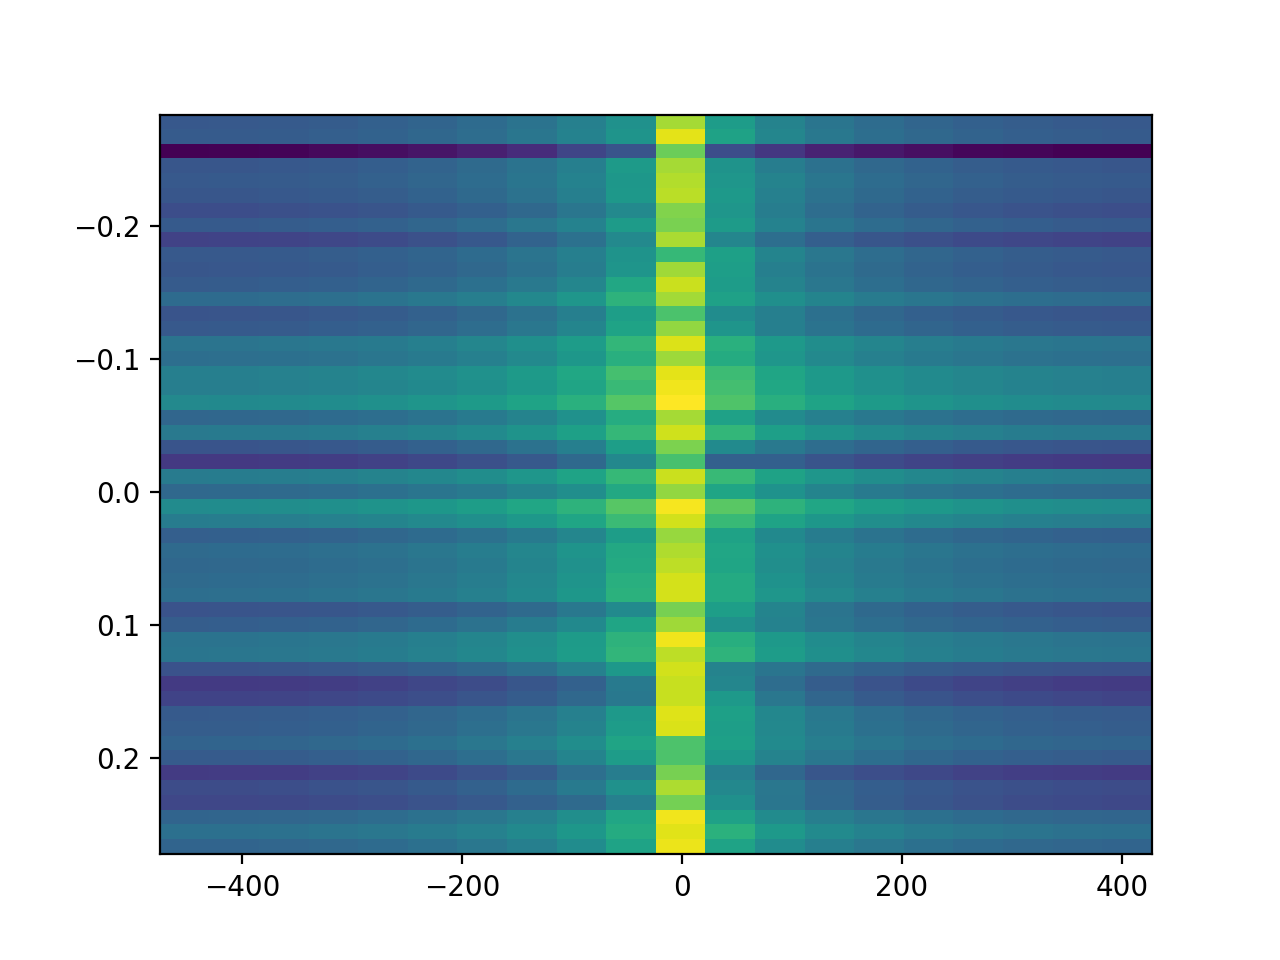

In [22]:
plt.figure()
plt.imshow((np.fft.fftshift(np.abs(vis_f[(0,5)])**2)), aspect='auto', norm=LogNorm(), extent=[delay[0]*1e9, delay[-1]*1e9, fringe[-1]*1e3, fringe[0]*1e3])

<IPython.core.display.Javascript object>


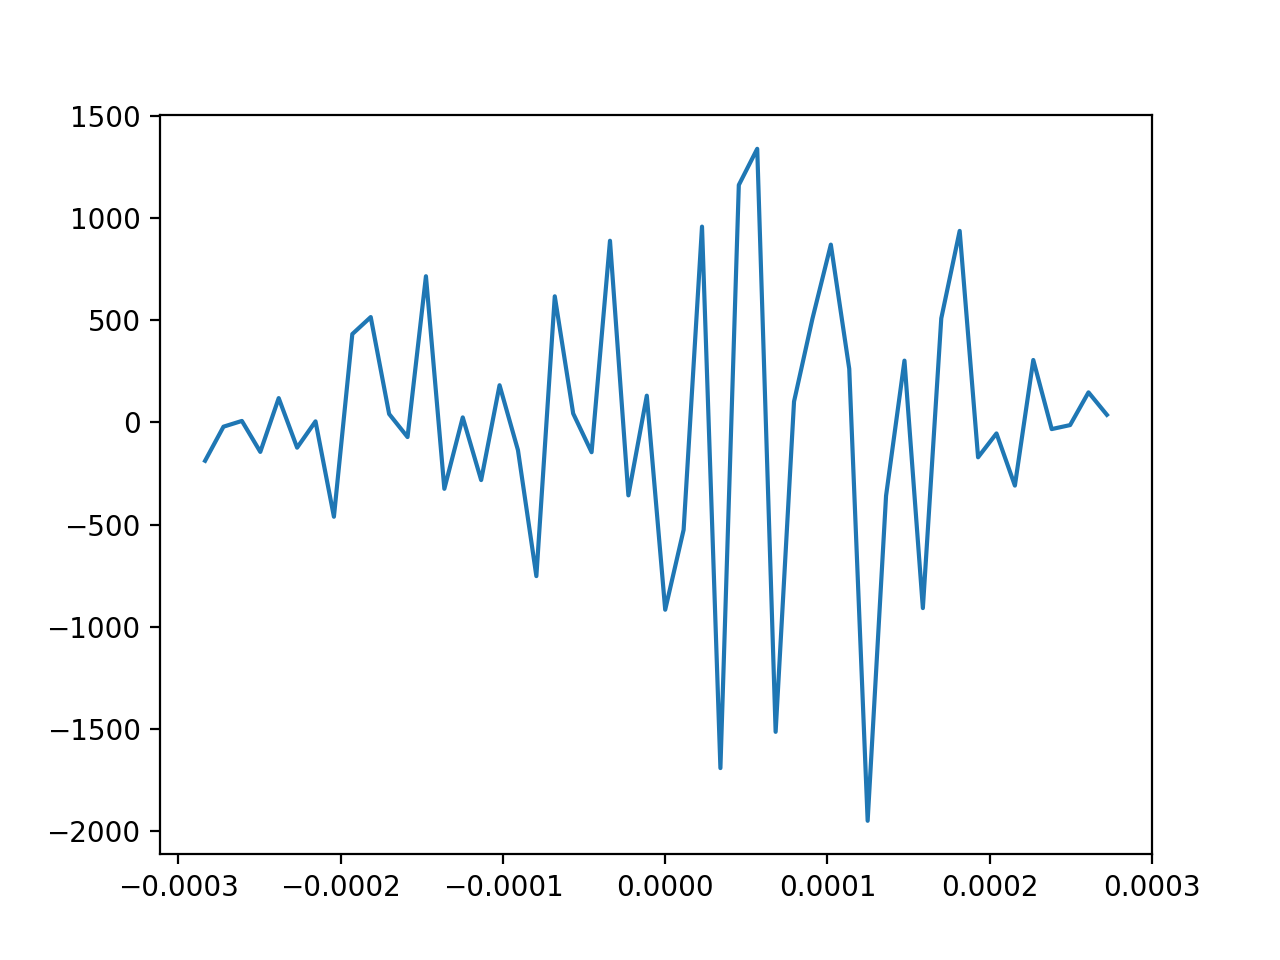

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [23]:
plt.figure()
plt.plot(fringe, np.fft.fftshift(vis_f[(0,1)][:,0]))

In [80]:
ants

{0: <Antenna.Ant at 0x81e412410>,
 1: <Antenna.Ant at 0x81e4123d0>,
 2: <Antenna.Ant at 0x81e412390>,
 3: <Antenna.Ant at 0x81e412350>,
 4: <Antenna.Ant at 0x81e412310>,
 5: <Antenna.Ant at 0x81e4122d0>,
 6: <Antenna.Ant at 0x81e412290>}

In [84]:
x.shape

(100,)

In [86]:
theta = np.linspace(0,np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
x = np.sin(theta)*np.cos(phi)
y = np.cos(theta)*np.cos(phi)

BEAM = ants[0].airy_beam(x, y, np.array([150]))

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

In [11]:
a = np.ones(10)
b = np.ones(9)

In [15]:
np.einsum('i,j->i', a, b)

array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9.])

* Investigate Visibility --One reading done and a video
** Auto-Correlations, Correlations --one reading and a video

* Insert a more realistic Foreground model PyGSM --Have installed and operatabale
** More realistic Foreground Model --Have ready by next meeting

* Next saturday 4hr hack session

* Create simulations with the 3 beam models that weve developed. 

* Develop slide show

* build Poster

In [102]:
from scipy.special import j1

In [108]:
airy = j1(10*x)/(10*x)

<IPython.core.display.Javascript object>


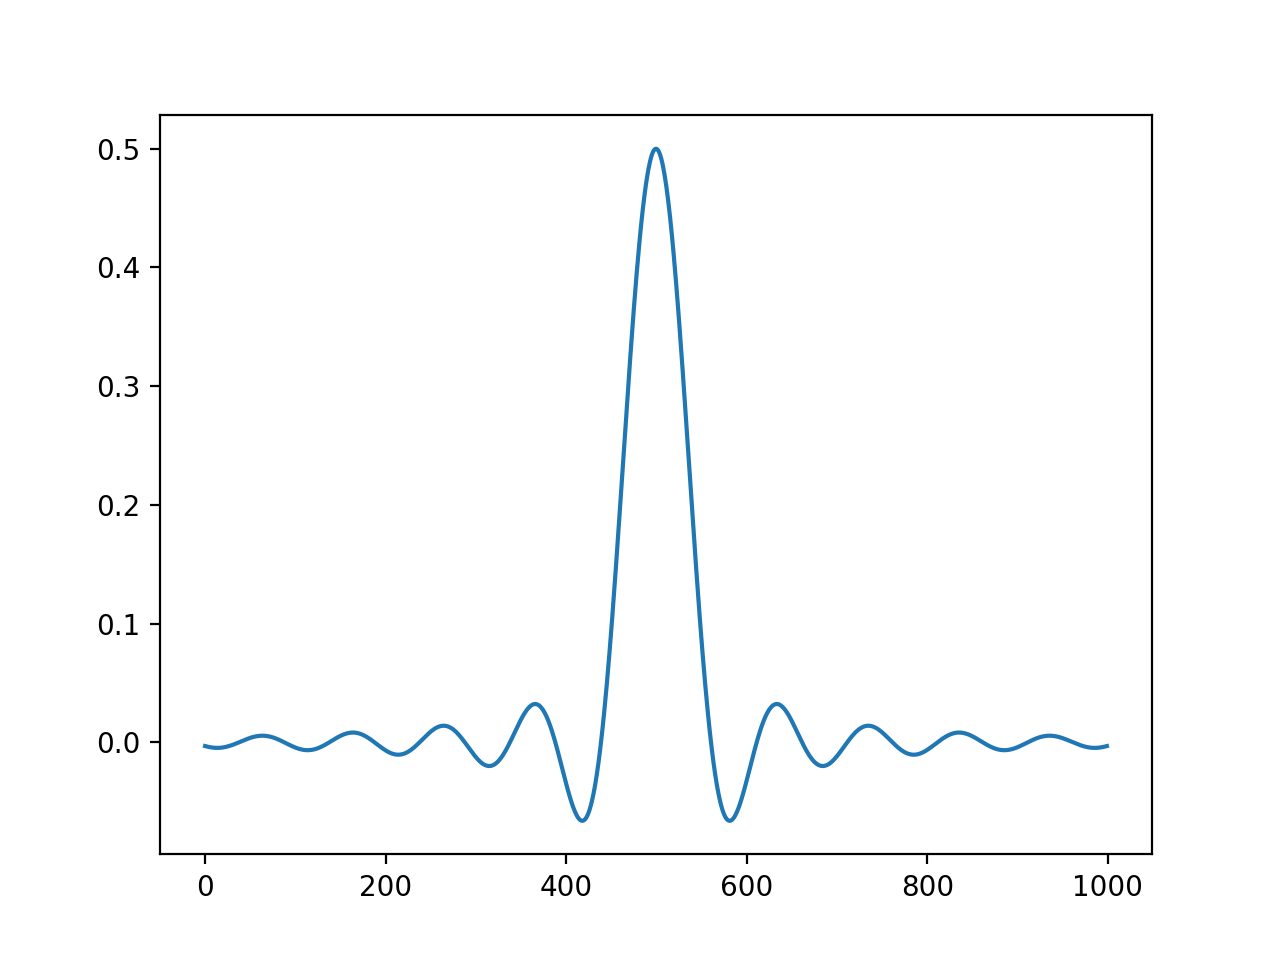

In [109]:
plt.figure()
plt.plot(airy)

In [110]:
airy_f = np.fft.ifft(airy)

<IPython.core.display.Javascript object>


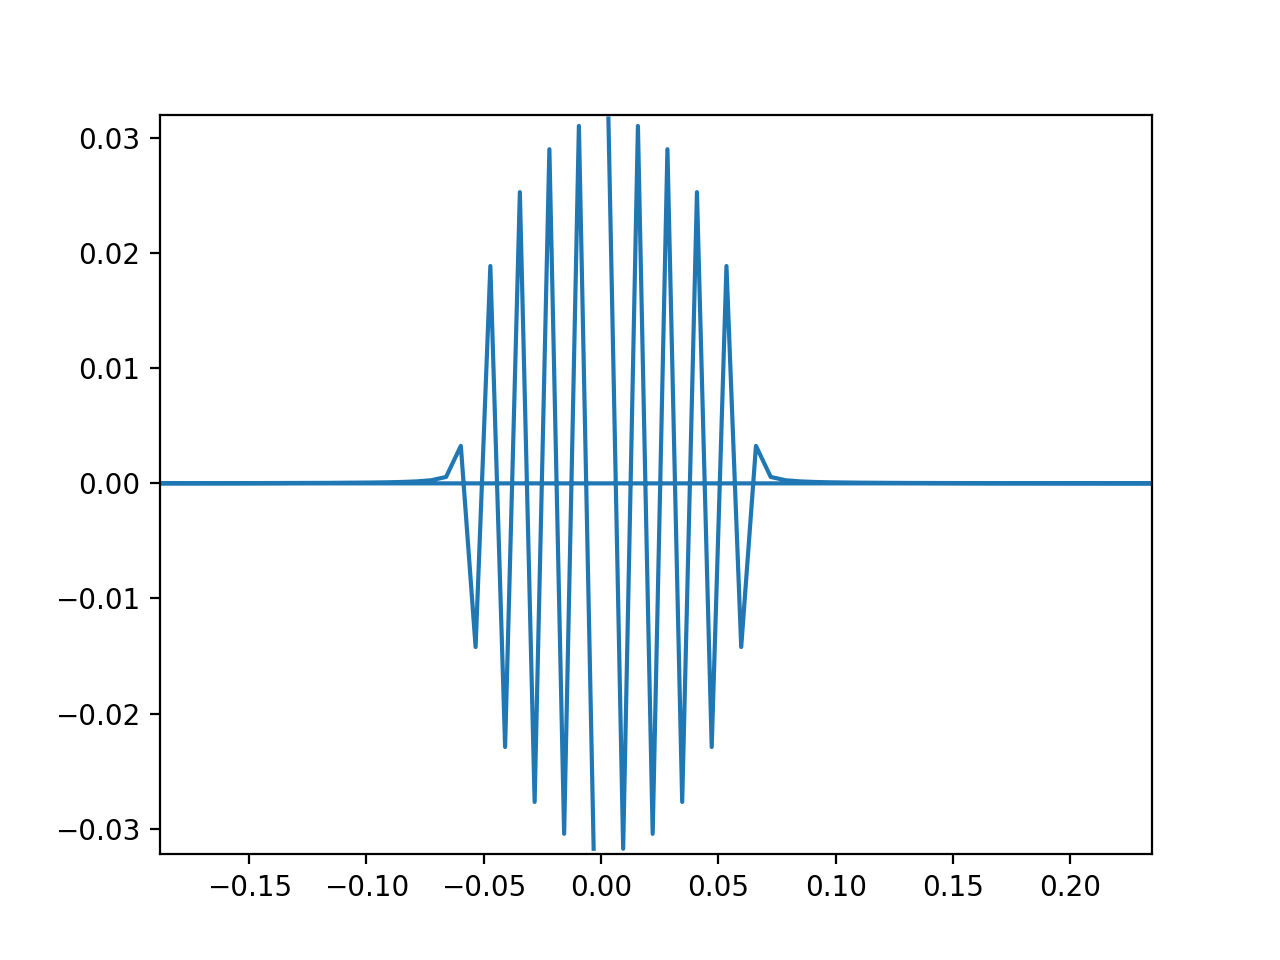

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [115]:
plt.figure()
plt.plot(np.fft.fftshift(x), airy_f)

In [107]:
x = np.linspace(-np.pi, np.pi, 1000)
y = np.random.randint(1, 10)*np.sin(np.random.randint(1, 10)*x) + np.random.randint(1, 10)*np.sin(np.random.randint(1, 10)*x)
y_o = np.concatenate((np.zeros(100), np.ones(800), np.zeros(100)))

<IPython.core.display.Javascript object>


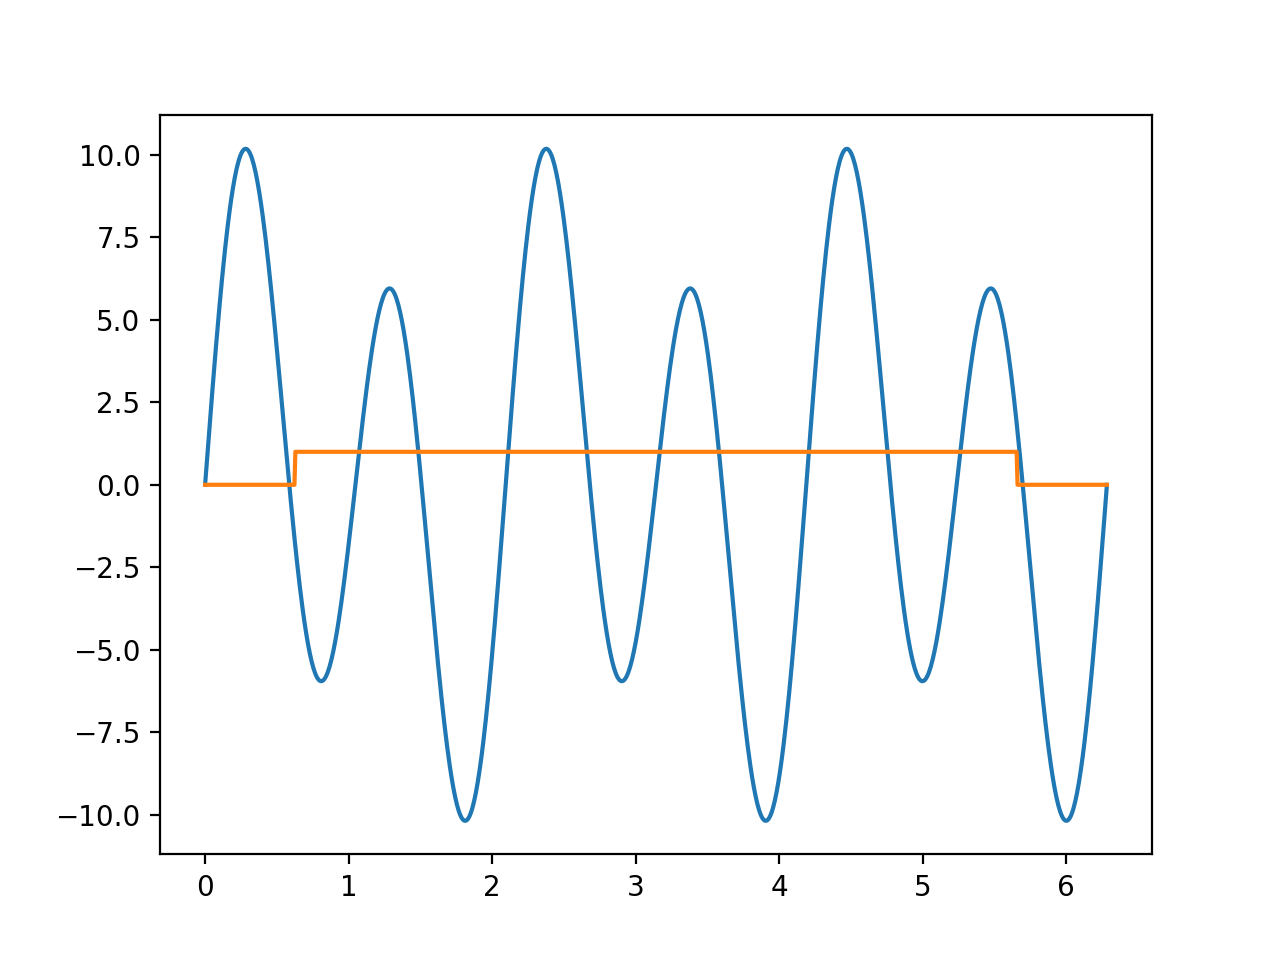

In [95]:
plt.figure()
plt.plot(x, y)
plt.plot(x, y_o)

In [96]:
x[1]-x[0]

0.006289474781961547

In [99]:
y_tilde = np.fft.fft(y)
y_beam = np.fft.fft(y_o)
x_tilde = np.fft.fftfreq(len(x), np.median(np.diff(x)))

<IPython.core.display.Javascript object>


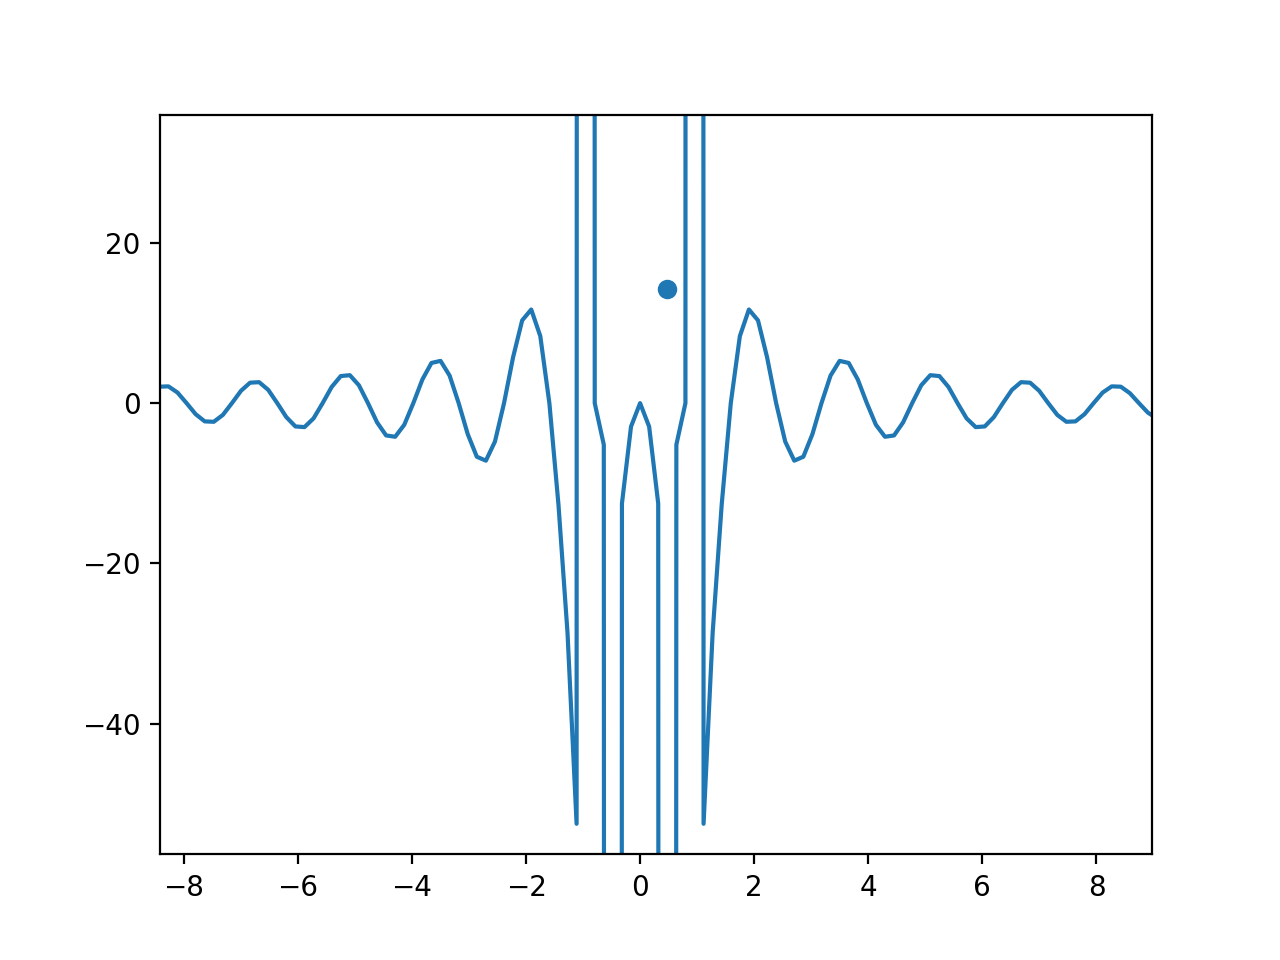

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


In [101]:
plt.figure()
# plt.plot(np.fft.fftshift(x_tilde), np.fft.fftshift(y_tilde))
# plt.plot(np.fft.fftshift(x_tilde), np.fft.fftshift(y_beam))
plt.plot(np.fft.fftshift(x_tilde), np.fft.fftshift(y_tilde*y_beam))


plt.scatter(x_tilde[3], y_tilde[3])

In [62]:
y_tilde = y_tilde*np.fft.fft(np.ones(len(y_tilde)))

In [78]:
y_tilde[np.arange(-5, 5)] = 0

In [80]:
y_new = np.fft.ifft(y_tilde)

<IPython.core.display.Javascript object>


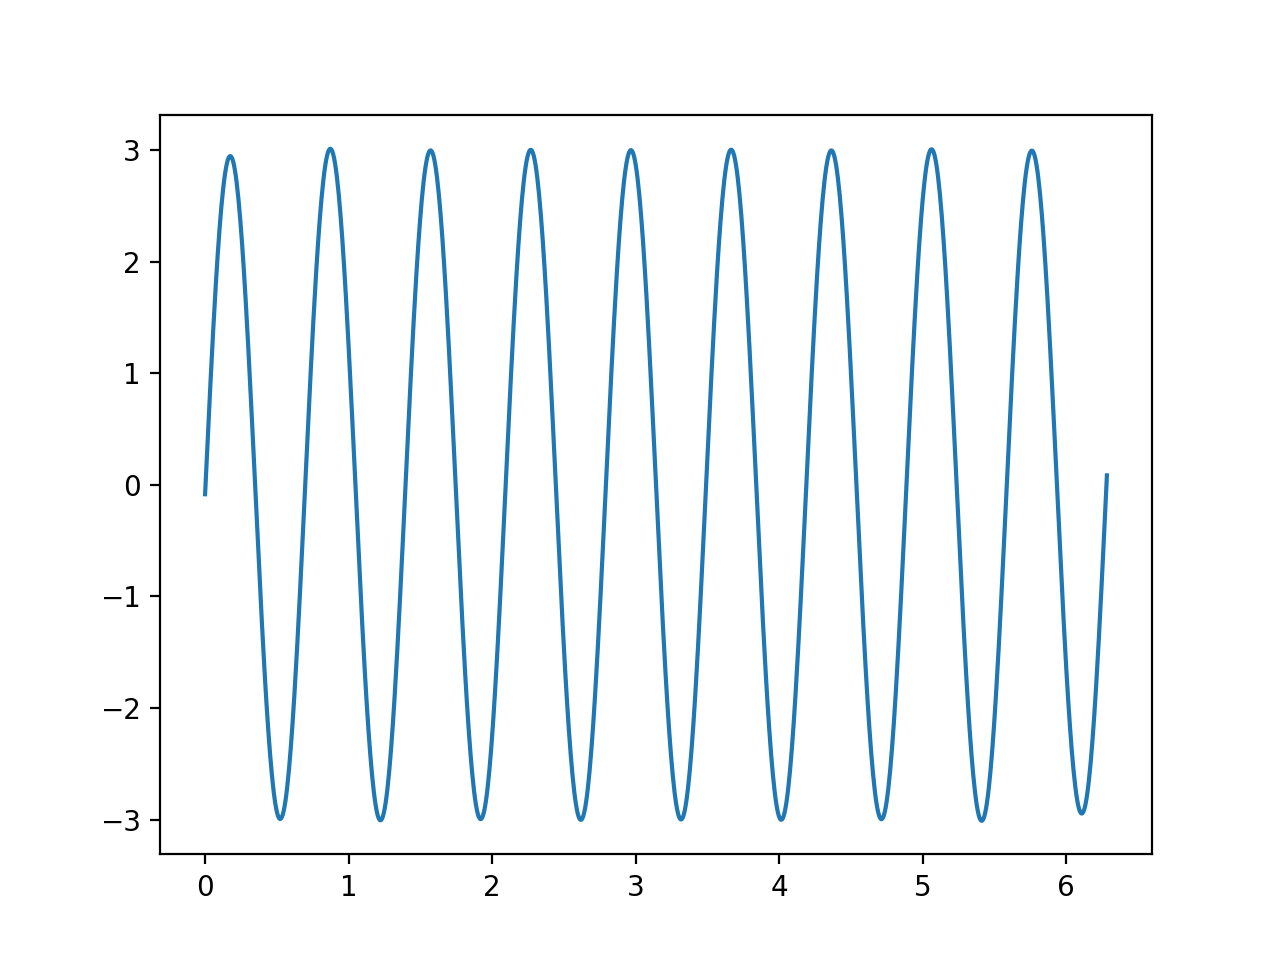

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [81]:
plt.figure()
plt.plot(x, y_new)

In [47]:
np.where(x_tilde<.38)
y_tilde[3]

(array([  0,   1,   2, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509,
        510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522,
        523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535,
        536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548,
        549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561,
        562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574,
        575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587,
        588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600,
        601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613,
        614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
        627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639,
        640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652,
        653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665,
        666, 667, 668, 669, 670, 671, 672, 673, 674

In [118]:
cor = np.correlate(airy, y, mode='same')

<IPython.core.display.Javascript object>


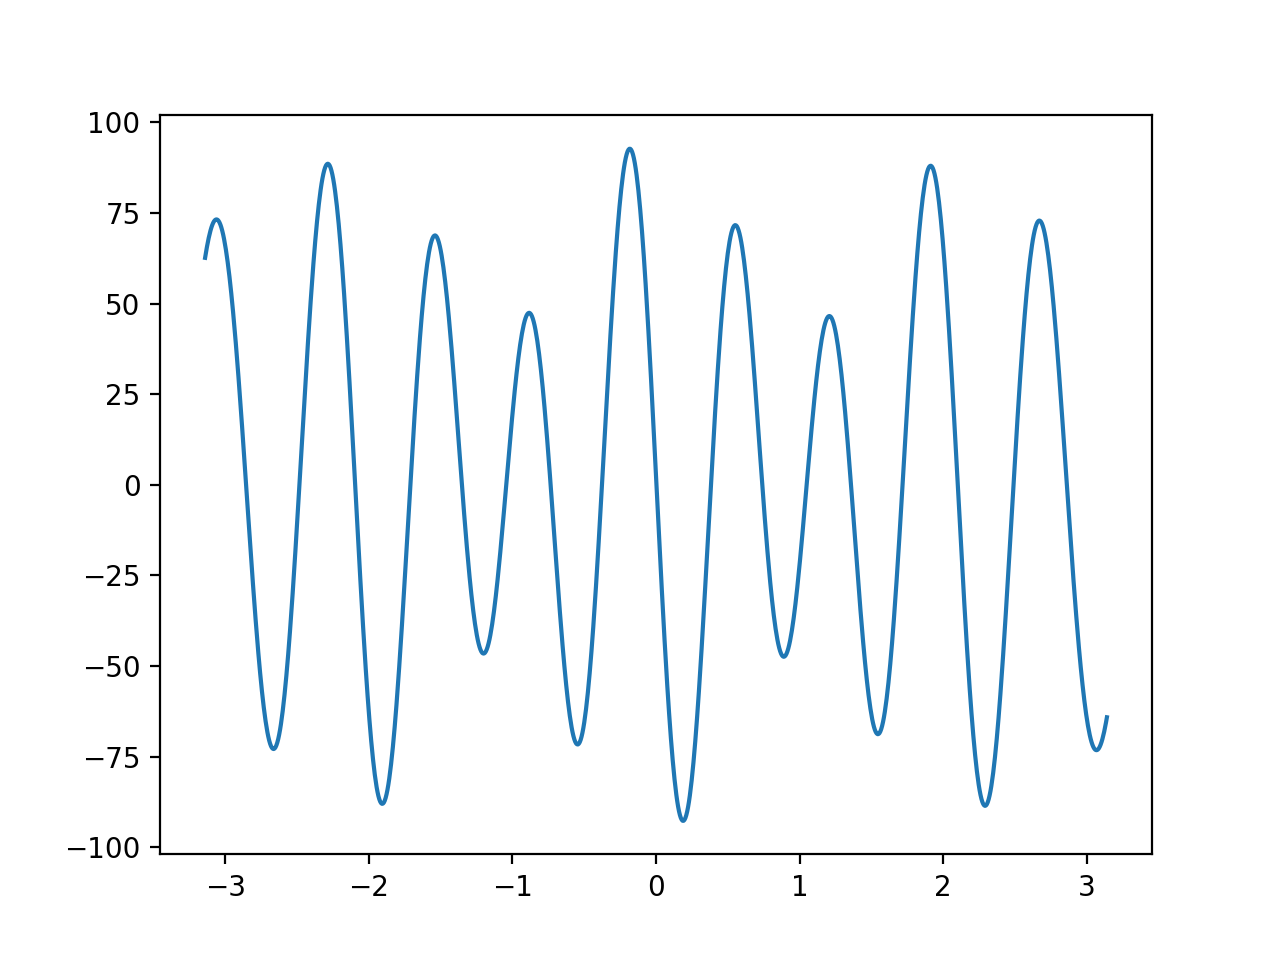

In [119]:
plt.figure()
plt.plot(x, cor)